In [ ]:
# uq360 version 0.2 needs to be installed
#!pip install uq360

In [1]:
try:
    from uq360.metrics import picp, mpiw, compute_regression_metrics
    from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

    from uq360.algorithms import * 
    from uq360.algorithms.actively_learned_model import ActivelyLearnedModel
    from uq360.algorithms.ensemble_heteroscedastic_regression import EnsembleHeteroscedasticRegression

    import pandas as pd
    import numpy as np
    import torch

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    print('All the libraries are found')
    
except:
    print("One or more libraries need to be installed")

All the libraries are found


In [ ]:
file_name = '/data/MGP/TestPointsN2_CH4_H2O_000.xlsx'
df=pd.read_excel(file_name,header=1).dropna(how='all', axis=1)
df.drop('#',axis=1,inplace=True)

In [23]:
def read_data(file_name):
    
    #xls_new = pd.ExcelFile(file_name)
    df=pd.read_excel(file_name,header=1).dropna(how='all', axis=1)
    df.drop('#',axis=1,inplace=True)
    
    return df

data = read_data(r'/data/MGP/TestPointsN2_CH4_H2O_000.xlsx')

In [24]:
data.shape

(63116, 36)

In [26]:
def create_new_col(df,col1,col2):
    phi_surge = 0.076
    df[col2] = 100*(df[col1]-phi_surge)/phi_surge
    
    return df

col1 = 'phi'
col2 = 'surge_distance_from_eq'
data = create_new_col(data,col1,col2)

In [28]:
def select_columns(df,columns,input_columns,output_columns):
    
    df = df[columns]
    
    df = pd.concat([df[input_columns],df[output_columns]],axis=1)
    
    return df

In [29]:
columns=['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power','phi',
         'Surge Distance','surge_distance_from_eq','GVFin','Qin [m3/s]','GVFout','Qv_out [m3/s]']
INPUT_C = ['Pin [kPa]','Tin [K]','N [rpm]','Differential Pressure [kPa]','Total Consumed power']
OUTPUT_C = ['surge_distance_from_eq']
data_1 = select_columns(data,columns,INPUT_C,OUTPUT_C)

In [30]:
data_1.shape

(63116, 6)

In [41]:
# scale the data and select the number of samples to be considered
def scale_data(df,samples):
    df_1 = df[0:samples]
    df_x = df_1.iloc[:, :-1].values
    y_labels = np.squeeze(df_1.iloc[:, -1:].values, axis=1)
    y_labels = y_labels.reshape((-1,1))

    # scale the values
    scaler = StandardScaler()
    scaling = scaler.fit(df_x)
    x_data = scaling.transform(df_x)
    
    
    return df, y_labels, x_data

data,y_labels,x_data = scale_data(data_1,20000)

In [42]:
''' 
    Offline sample and query, two mandatory arguments (and the data):
    - Position where to start sampling
    - Number of points to sample
'''
def sample_(start_index, n_points, X_data=x_data):
    return x_data[start_index:start_index+n_points,:]

def querry_(start_index, n_points, y_labels=y_labels):
    return y_labels[start_index:start_index+n_points]


In [99]:
# define configuration for both models, regression baseline and regression with Active Learning
def config_():
    device = torch.device("cpu")

    # define config for Heteroscedastic regression
    config_HR = {"num_features": 5, "num_hidden": 32, "num_outputs": 1, "batch_size": 16, "num_epochs": 10,
                      "lr": 0.001}
    HR_kwargs = {"model_type":'mlp',
                   "config": config_HR,
                   "device": device}
    # define config for ensemble
    config_ensemble = {"num_models": 1, 
              "batch_size": 16,
              "model_kwargs":HR_kwargs, }

    ninit = 128 
    T = 2 #4 # do not change this,
    # define config for active learning object
    # T = # no of iterations
    # K = # no of uncertain points
    #K=64
    config_AL = {"num_init": 512 , 
     "T": 2, 
     "K": 16, 
     "M": 4, 
     "sampling_function": sample_, 
     "querry_function" : querry_,
     "model_function": EnsembleHeteroscedasticRegression,
     "model_kwargs": {"model_type":'ensembleheteroscedasticregression', 
                                                 "config":config_ensemble, 
                                                 "device":device}, }
    
    return config_HR,HR_kwargs,config_AL
config_HR,HR_kwargs,config_AL = config_()

In [100]:
# Verify that the data set has the good dimension
def verify_dimension(data_x,config_AL,config_HR):
    
    assert(data_x.shape[0] >= config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"])
    assert(data_x.shape[1] == config_HR["num_features"])
    
    return True

verify_dimension(x_data,config_AL,config_HR)

True

In [122]:
import al_model
from al_model import ActivelyLearnedModel

def baseline(config_AL):
    # Baseline without AL
    
    K_train_list = [8,16, 32, 64, 128, 256,512,1024]  # T=2 better graph
    #K_train_list = [10,20,40,80,160,320,640,1280]   # T=2 better graph
    
    frac_err_baseline = []
    ninit=128
    N_test = 512
    device = torch.device("cpu")
    T=2
    for i in range(len(K_train_list)):

        # Update dictiorary to have no active learning and the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit + K_train_list[i] * T
        print(config_AL["num_init"])
        config_AL["T"] = 0  # no AL here

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit() 

        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))
        print(X_test.shape,y_test.shape)

        res = uq_model.predict(X_test) 
        
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_baseline.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        print('iteration---------',i)
        
    return  frac_err_baseline

In [123]:
errors_baseline=baseline(config_AL)

144
(144, 5) (144, 1)

Training model 0

Epoch: 0, loss = 898.4305962456598
Epoch: 1, loss = 841.9984130859375
Epoch: 2, loss = 791.683580186632
Epoch: 3, loss = 746.269066704644
Epoch: 4, loss = 704.8650546603733
Epoch: 5, loss = 666.8555365668403
Epoch: 6, loss = 631.6302931043837
Epoch: 7, loss = 598.7425062391493
Epoch: 8, loss = 567.9075080023872
Epoch: 9, loss = 538.954857720269

Training model 1

Epoch: 0, loss = 965.1288452148438
Epoch: 1, loss = 884.461934407552
Epoch: 2, loss = 814.487528483073
Epoch: 3, loss = 753.5339423285591
Epoch: 4, loss = 700.1666734483506
Epoch: 5, loss = 653.0705057779948
Epoch: 6, loss = 611.1160888671875
Epoch: 7, loss = 573.4895528157551
Epoch: 8, loss = 539.5186021592882
Epoch: 9, loss = 508.7084757486979

Training model 2

Epoch: 0, loss = 831.8299323187933
Epoch: 1, loss = 782.1129998101128
Epoch: 2, loss = 736.9740024142795
Epoch: 3, loss = 695.5342746310763
Epoch: 4, loss = 657.2066650390625
Epoch: 5, loss = 621.733147515191
Epoch: 6, loss = 

Epoch: 9, loss = 248.1901798248291

Training model 2

Epoch: 0, loss = 759.4494895935056
Epoch: 1, loss = 651.6540489196776
Epoch: 2, loss = 564.7783508300781
Epoch: 3, loss = 492.6186580657959
Epoch: 4, loss = 431.8582611083984
Epoch: 5, loss = 380.4859402974447
Epoch: 6, loss = 337.16309611002606
Epoch: 7, loss = 300.68866539001465
Epoch: 8, loss = 269.88222694396967
Epoch: 9, loss = 243.85606034596762

Training model 3

Epoch: 0, loss = 924.5444018046061
Epoch: 1, loss = 769.0888074239095
Epoch: 2, loss = 656.282283782959
Epoch: 3, loss = 569.7670822143555
Epoch: 4, loss = 500.2990659077962
Epoch: 5, loss = 442.71903610229487
Epoch: 6, loss = 394.13672383626306
Epoch: 7, loss = 352.8475462595622
Epoch: 8, loss = 317.7144050598144
Epoch: 9, loss = 287.74806086222327

Training model 4

Epoch: 0, loss = 938.7463455200194
Epoch: 1, loss = 795.9606463114419
Epoch: 2, loss = 683.6434847513837
Epoch: 3, loss = 592.9776382446289
Epoch: 4, loss = 518.4671815236409
Epoch: 5, loss = 456.626819

In [124]:
errors_baseline

[0.9832069153690315,
 0.981279078934709,
 0.9772570872177739,
 0.968153441778212,
 0.947666175885187,
 0.9032063961193391,
 0.8050311975395468,
 0.6547413422749819]

In [127]:
import al_model
from al_model import ActivelyLearnedModel


def with_al(config_AL):
    # AL, ensemble of 5 NNs
    frac_err_AL_ens = []
    device = torch.device("cpu")
    
    #checkpoint=keras.callbacks.ModelCheckpoint("mcp_AL.h5", save_best_only=True)
    K_train_list = [8,16, 32, 64, 128, 256,512,1024] # make it as a global variable
    #K_train_list = [10,20,40,80,160,320,640,1280]
    N_test = 512
    ninit=128
    T=2
    for i in range(len(K_train_list)):

        # Update dictiorary for the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit
        config_AL["K"] = K_train_list[i]
        config_AL["M"] = 4
        config_AL["T"] = T

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit()

        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))
        
        print('test set size is', X_test.shape)

        res = uq_model.predict(X_test)
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_AL_ens.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        
    return frac_err_AL_ens


In [128]:
errors_al = with_al(config_AL)

(128, 5) (128, 1)

Training model 0

Epoch: 0, loss = 1191.2982559204102
Epoch: 1, loss = 1112.3001022338867
Epoch: 2, loss = 1042.4789962768555
Epoch: 3, loss = 979.9024047851562
Epoch: 4, loss = 923.5063323974609
Epoch: 5, loss = 872.1197929382324
Epoch: 6, loss = 824.9293441772461
Epoch: 7, loss = 781.4889907836914
Epoch: 8, loss = 741.2865028381348
Epoch: 9, loss = 703.913215637207

Training model 1

Epoch: 0, loss = 1466.8523406982422
Epoch: 1, loss = 1361.7539520263672
Epoch: 2, loss = 1271.8415603637695
Epoch: 3, loss = 1194.2659530639648
Epoch: 4, loss = 1126.8563232421875
Epoch: 5, loss = 1067.5989875793457
Epoch: 6, loss = 1015.0295562744141
Epoch: 7, loss = 967.7179412841797
Epoch: 8, loss = 924.6259880065918
Epoch: 9, loss = 885.1318016052246

Training model 2

Epoch: 0, loss = 1071.7694931030273
Epoch: 1, loss = 1010.6565399169922
Epoch: 2, loss = 955.9369773864746
Epoch: 3, loss = 906.2810859680176
Epoch: 4, loss = 860.9972839355469
Epoch: 5, loss = 819.4949264526367
Epoc

Epoch: 4, loss = 393.5498962402344
Epoch: 5, loss = 371.15004984537757
Epoch: 6, loss = 350.43325127495655
Epoch: 7, loss = 331.28615993923614
Epoch: 8, loss = 313.61203850640186
Epoch: 9, loss = 297.29043070475257

Training model 3

Epoch: 0, loss = 574.3634304470487
Epoch: 1, loss = 536.790276421441
Epoch: 2, loss = 503.0679083930121
Epoch: 3, loss = 472.5042673746745
Epoch: 4, loss = 444.76968044704864
Epoch: 5, loss = 419.5035756429037
Epoch: 6, loss = 396.4086473253038
Epoch: 7, loss = 375.25295003255206
Epoch: 8, loss = 355.8215637207031
Epoch: 9, loss = 337.9070705837674

Training model 4

Epoch: 0, loss = 590.381096733941
Epoch: 1, loss = 552.4956207275391
Epoch: 2, loss = 518.2287919786241
Epoch: 3, loss = 486.99664984809027
Epoch: 4, loss = 458.55838012695307
Epoch: 5, loss = 432.6700337727865
Epoch: 6, loss = 409.028074476454
Epoch: 7, loss = 387.3625962999132
Epoch: 8, loss = 367.4210425482855
Epoch: 9, loss = 348.98651292588977
(144, 5) (144, 1)
(16, 5) (16, 1)

Training m

Epoch: 0, loss = 297.65268325805664
Epoch: 1, loss = 273.71052296956384
Epoch: 2, loss = 252.51088841756183
Epoch: 3, loss = 233.72858937581378
Epoch: 4, loss = 217.10978635152176
Epoch: 5, loss = 202.34440549214685
Epoch: 6, loss = 189.16579818725583
Epoch: 7, loss = 177.36699930826822
Epoch: 8, loss = 166.7682202657064
Epoch: 9, loss = 157.20245297749835
(192, 5) (192, 1)
test set size is (512, 5)
(128, 5) (128, 1)

Training model 0

Epoch: 0, loss = 897.685188293457
Epoch: 1, loss = 848.5712051391602
Epoch: 2, loss = 804.253589630127
Epoch: 3, loss = 763.6846466064453
Epoch: 4, loss = 726.2823677062988
Epoch: 5, loss = 691.5584869384766
Epoch: 6, loss = 659.1344413757324
Epoch: 7, loss = 628.6419715881348
Epoch: 8, loss = 599.8716239929199
Epoch: 9, loss = 572.6521377563477

Training model 1

Epoch: 0, loss = 972.3930740356445
Epoch: 1, loss = 899.7449493408203
Epoch: 2, loss = 835.8917846679688
Epoch: 3, loss = 779.40576171875
Epoch: 4, loss = 729.3008918762207
Epoch: 5, loss = 684

Epoch: 4, loss = 296.4165287017822
Epoch: 5, loss = 269.1150665283203
Epoch: 6, loss = 246.07673358917236
Epoch: 7, loss = 226.38351154327393
Epoch: 8, loss = 209.35045289993286
Epoch: 9, loss = 194.47290229797363

Training model 2

Epoch: 0, loss = 464.06555557250977
Epoch: 1, loss = 412.9252452850342
Epoch: 2, loss = 369.8240079879761
Epoch: 3, loss = 333.07129096984863
Epoch: 4, loss = 301.5694808959961
Epoch: 5, loss = 274.5171060562134
Epoch: 6, loss = 251.13413763046265
Epoch: 7, loss = 230.80370235443115
Epoch: 8, loss = 213.07958602905273
Epoch: 9, loss = 197.57088708877563

Training model 3

Epoch: 0, loss = 554.3867225646973
Epoch: 1, loss = 488.3404417037964
Epoch: 2, loss = 434.6854934692383
Epoch: 3, loss = 390.2869920730591
Epoch: 4, loss = 352.95217990875244
Epoch: 5, loss = 321.1543245315552
Epoch: 6, loss = 293.84046459198
Epoch: 7, loss = 270.1591634750366
Epoch: 8, loss = 249.50632047653198
Epoch: 9, loss = 231.3562126159668

Training model 4

Epoch: 0, loss = 550.07

Epoch: 3, loss = 71.71411910057068
Epoch: 4, loss = 61.02555522918701
Epoch: 5, loss = 52.665421628952025
Epoch: 6, loss = 45.987871742248544
Epoch: 7, loss = 40.5767789363861
Epoch: 8, loss = 36.1354585170746
Epoch: 9, loss = 32.456752920150755

Training model 4

Epoch: 0, loss = 137.55263023376466
Epoch: 1, loss = 108.00955133438111
Epoch: 2, loss = 88.1063849925995
Epoch: 3, loss = 73.80295867919922
Epoch: 4, loss = 63.0000300884247
Epoch: 5, loss = 54.55920925140382
Epoch: 6, loss = 47.799367094039916
Epoch: 7, loss = 42.282599902153024
Epoch: 8, loss = 37.73187654018402
Epoch: 9, loss = 33.94451801776886
(640, 5) (640, 1)
test set size is (512, 5)
(128, 5) (128, 1)

Training model 0

Epoch: 0, loss = 897.685188293457
Epoch: 1, loss = 848.5712051391602
Epoch: 2, loss = 804.253589630127
Epoch: 3, loss = 763.6846466064453
Epoch: 4, loss = 726.2823677062988
Epoch: 5, loss = 691.5584869384766
Epoch: 6, loss = 659.1344413757324
Epoch: 7, loss = 628.6419715881348
Epoch: 8, loss = 599.871

(1024, 5) (1024, 1)

Training model 0

Epoch: 0, loss = 394.07933680216473
Epoch: 1, loss = 243.64848592546252
Epoch: 2, loss = 170.8536591000027
Epoch: 3, loss = 128.40655220879452
Epoch: 4, loss = 100.71756288740369
Epoch: 5, loss = 81.28125492731729
Epoch: 6, loss = 67.07351803779602
Epoch: 7, loss = 56.381545199288276
Epoch: 8, loss = 48.15647406048244
Epoch: 9, loss = 41.711830986870645

Training model 1

Epoch: 0, loss = 350.83792071872296
Epoch: 1, loss = 212.97111405266656
Epoch: 2, loss = 150.11392688751226
Epoch: 3, loss = 113.84812302059593
Epoch: 4, loss = 90.21601284874808
Epoch: 5, loss = 73.61814716127184
Epoch: 6, loss = 61.38816661304895
Epoch: 7, loss = 52.079265435536705
Epoch: 8, loss = 44.846155802408845
Epoch: 9, loss = 39.13890020052593

Training model 2

Epoch: 0, loss = 339.02530860900885
Epoch: 1, loss = 211.39515442318378
Epoch: 2, loss = 147.55048338572183
Epoch: 3, loss = 110.91345771153769
Epoch: 4, loss = 87.51840930514867
Epoch: 5, loss = 71.349280463324

In [129]:
errors_al

[0.9321582132013233,
 0.9262153489320486,
 0.9141693532647568,
 0.888057522228071,
 0.831039806308556,
 0.7336310506056534,
 0.6033914633661223,
 0.5604999867488258]

In [130]:
def compare_err_plot(frac_err_baseline,frac_err_AL_ens):
    
    K_train_list = [8,16, 32, 64, 128, 256,512,1024]  # make it global
    #K_train_list = [10,20,40,80,160,320,640,1280]
    ninit = 128   #128
    T=2     
    N_train_list = ninit + T * np.array(K_train_list)
    plt.style.use("classic")
    fig = plt.figure()
    plt.plot(N_train_list,frac_err_baseline, ".-", label="Baseline")
    plt.plot(N_train_list,frac_err_AL_ens, ".-", label="Active learning, ensemble")
    plt.ylabel('Fractional error on test set')
    plt.xlabel('Number of training points')
    plt.legend()
    plt.show()
    
    return 

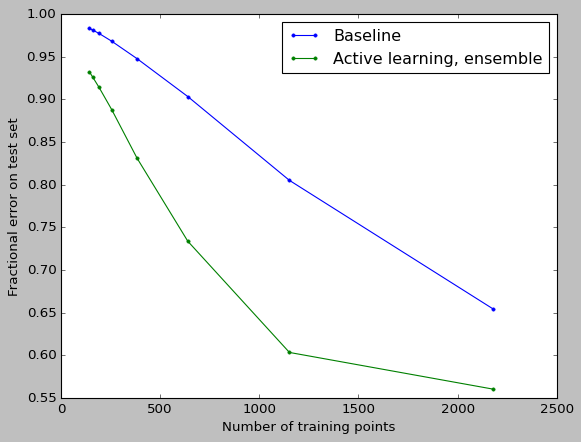

In [131]:
compare_err_plot(errors_baseline,errors_al)